![title](https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png)

# Photometry of a JWST/NIRCam extragalactic field with Photutils
Author: Larry Bradley, Space Telescope Science Institute<br>
Data last modified: 2025-02-27

## Tutorial Overview
This tutorial will demonstrate how to use [Photutils](https://photutils.readthedocs.io/) to perform multiband NIRCam photometry on an extragalactic field.

Photutils is a Python library that provides commonly-used tools and key functionality for detecting and performing photometry of astronomical sources. Tools are provided for
* background estimation
* star finding
* source detection and extraction
* aperture photometry
* PSF photometry
* image segmentation
* centroids
* radial profiles
* elliptical isophote fitting

It is a coordinated package of [Astropy](https://docs.astropy.org/en/stable/) and integrates well with other Astropy packages, making it a powerful tool for astronomical image analysis.

## Outline:

1. Load Datasets
1. Background Subtraction
1. Aperture Photometry
1. Creating a multiband segmentation-based catalog
    1. Creating a Detection Image
    1. Source Extraction via Image Segmentation
    1. Source Deblending
    1. Modifying a Segmentation Image
    1. SourceFinder convenience class
    1. Source Measurements: Source Catalog
    1. Creating a Multiband Catalog
    1. Catalog Exploration

## Import packages

In [1]:
import os
from astroquery.mast import Observations
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.convolution import convolve
from astropy.io import fits
from astropy.table import hstack
from astropy.visualization import SimpleNorm, simple_norm
from astropy.wcs import WCS
from photutils.aperture import (ApertureStats, CircularAperture,
                                SkyCircularAperture, aperture_photometry, 
                                aperture_to_region)
from photutils.background import (Background2D, BiweightLocationBackground,
                                  BiweightScaleBackgroundRMS)
from photutils.segmentation import (SourceCatalog,
                                    deblend_sources, detect_sources,
                                    make_2dgaussian_kernel)
from photutils.utils import CutoutImage
from regions import Regions
from scipy.ndimage import grey_dilation

# Change some default plotting parameters
mpl.rcParams['figure.constrained_layout.use'] = True
mpl.rcParams['figure.max_open_warning'] = 40
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.origin'] = 'lower'

# Enable interactive plots
# %matplotlib ipympl

In [2]:
def download_files(files_to_download):
    """Download a list of files from MAST.

    Parameters
    ----------
    files_to_download : list
        List of filenames
    """
    for file in files_to_download:
        # Check if the file already exists in the current working directory
        if os.path.exists(file):
            print(f"File {file} already exists. Skipping download.")
            continue
        cal_uri = f'mast:HLSP/ceers/nircam/{file}.gz'
        Observations.download_file(cal_uri)
        os.system('gunzip ' + file + '.gz')

## Load Datasets

### Data Overview

We will use 3 JWST/NIRCam images in the F115W, F200W, and F356W filters from the [Cosmic Evolution Early Release Science Survey (CEERS)](https://ceers.github.io/) survey.

These are fully-calibration High-level Science Products (HLSPs) produced by the CEERS team of their [NIRCam 2 pointing](https://ceers.github.io/dr05.html) within the Extended Groth Strip (EGS) HST legacy field. The full CEERS data includes 7 NIRCam filters (F115W, F150W, F200W, F277W, F356W, F410M, F444W) plus MIRI and NIRSpec data. The NIRCam data were taken in parallel to prime NIRSpec observations.

The images are pixel aligned and have a pixel scale of 30 mas/pixel.

In [3]:
fn1 = 'hlsp_ceers_jwst_nircam_nircam2_f115w_v0.5_i2d.fits'
fn2 = 'hlsp_ceers_jwst_nircam_nircam2_f200w_v0.5_i2d.fits'
fn3 = 'hlsp_ceers_jwst_nircam_nircam2_f356w_v0.5_i2d.fits'

In [4]:
download_files([fn1, fn2, fn3])

File hlsp_ceers_jwst_nircam_nircam2_f115w_v0.5_i2d.fits already exists. Skipping download.
File hlsp_ceers_jwst_nircam_nircam2_f200w_v0.5_i2d.fits already exists. Skipping download.
File hlsp_ceers_jwst_nircam_nircam2_f356w_v0.5_i2d.fits already exists. Skipping download.


Let's see what's in these files using the `fits.info()` function.

In [5]:
fits.info(fn1)

Filename: hlsp_ceers_jwst_nircam_nircam2_f115w_v0.5_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     374   ()      
  1  SCI_BKSUB     1 ImageHDU        76   (11000, 6450)   float64   
  2  SCI           1 ImageHDU        75   (11000, 6450)   float32   
  3  ERR           1 ImageHDU        10   (11000, 6450)   float32   
  4  CON           1 ImageHDU         9   (11000, 6450)   int32   
  5  WHT           1 ImageHDU         9   (11000, 6450)   float32   
  6  VAR_POISSON    1 ImageHDU         9   (11000, 6450)   float32   
  7  VAR_RNOISE    1 ImageHDU         9   (11000, 6450)   float32   
  8  VAR_FLAT      1 ImageHDU         9   (11000, 6450)   float32   
  9  BKGD          1 ImageHDU        39   (11000, 6450)   float64   
 10  BKGMASK       1 ImageHDU        39   (11000, 6450)   float32   
 11  HDRTAB        1 BinTableHDU    816   96R x 403C   [23A, 5A, 3A, 48A, 6A, 13A, 5A, 5A, 7A, 10A, 4A, L, D, D, D, D, 4A, 18A, 57A, 22A,

Note that these files have extra extensions that are not in the pipeline-produced [i2d files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#resampled-2-d-data-i2d-and-s2d) (e.g., SCI_BKSUB, BKGD, BKGMASK)

Let's load the NIRCam F115W image and display it.

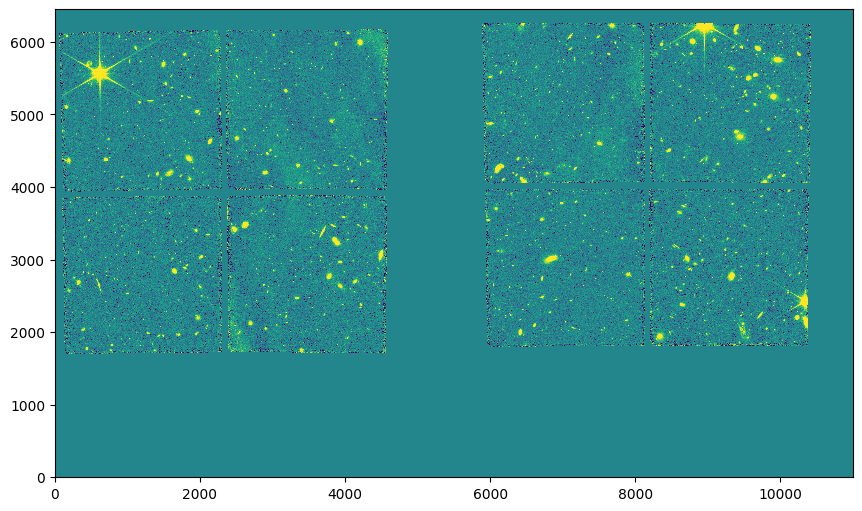

In [7]:
data = fits.getdata(fn1, ext=2)
snorm = SimpleNorm('sqrt', percent=98)
norm = snorm(data[data != 0])
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(data, norm=norm);

There are 2 NIRCam modules (A & B), each with [4 NIRCam short-wavelength (SW) detectors](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-observing-modes/nircam-imaging#gsc.tab=0).  All 8 SW detectors are 2k x 2k. There are also 2 2k x 2k long wavelength detectors, one covering each module. We see the SW detector gaps in each NIRCam module because these were parallel observations to NIRSpec prime observations. The prime observations had only very small dithers.

### Data Units

The JWST calibration pipeline produces images in units of MJy/sr. The unit is stored in the FITS header in the `BUNIT` key.

In [ ]:
header = fits.getheader(fn1, ext=2)
header['BUNIT']

In [ ]:
data_unit = u.Unit(header['BUNIT'])
data_unit

In [ ]:
# another way to create the unit
u.MJy / u.sr

The pixel area in steradians is stored in the FITS header in the `PIXAR_SR` key.

In [ ]:
header['PIXAR_SR']

Let's use Astropy units to calculate a scale factor to convert our original data in units of MJy/sr to μJy.

In [ ]:
unit = u.uJy
unit_conv = ((1 * data_unit) * (header['PIXAR_SR'] * u.sr)).to(unit)
unit_conv

### Load and Display the Data

Let's load the data. We'll use only one of the NIRCam modules. We'll also convert the units from MJy/sr to μJy.

In [ ]:
# define a tuple of slice objects to extract only 1 NIRCam module
slc = (slice(1650, 6450), slice(0, 4700))


def load_data(filename):
    data = {}
    with fits.open(filename) as hdul:
        data['filter'] = filename.split('_')[6]
        data['sci_bksub'] = hdul[1].data[slc]
        data['sci'] = hdul[2].data[slc]
        data['err'] = hdul[3].data[slc]
        data['var_rnoise'] = hdul[7].data[slc]
        data['wcs'] = WCS(hdul[1].header)[slc]

        # convert the units in-place
        data['sci_bksub'] *= unit_conv.value
        data['sci_bksub'] <<= unit_conv.unit
        data['sci'] *= unit_conv.value
        data['sci'] <<= unit_conv.unit
        data['err'] *= unit_conv.value
        data['err'] <<= unit_conv.unit
        data['var_rnoise'] *= unit_conv.value ** 2
        data['var_rnoise'] <<= unit_conv.unit ** 2
    return data


f115w = load_data(fn1)
f200w = load_data(fn2)
f356w = load_data(fn3)
data = (f115w, f200w, f356w)

Let's display the images.

In [ ]:
snorm = SimpleNorm('sqrt', percent=98)
norm = snorm(data[2]['sci'])

nimg = len(data)
fig, ax = plt.subplots(ncols=nimg, figsize=(12, 4), constrained_layout=True)
for i in range(nimg):
    ax[i].imshow(data[i]['sci'].value, norm=norm)
    ax[i].set_title(data[i]['filter'].upper())

## Background Subtraction

Let's plot the histograms of the pixel values near zero to see if there is any background pedestal. 

The CEERS team already subtracted a constant background value from each image.

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))

for i in range(nimg):
    vals = data[i]['sci'].value
    vals = vals[vals != 0]
    ax[i].hist(vals, bins=150, range=(-0.001, 0.001))
    ax[i].set_title(data[i]['filter'].upper())
    ax[i].axvline(0, color='red', ls='dotted')

### 2D Background Estimation

To remove the varying residual background, we can use the `photutils` [Background2D](https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html) class.

This class can be used to estimate a 2D background and background RMS noise in an image.

The background is estimated using (sigma-clipped) statistics in each box of a grid that covers the input data to create a low-resolution background map.

The final background map is calculated by interpolating the low-resolution background map.

#### Source Mask

To get the best possible background estimate, we need to first create a mask of the sources in the image.

Let's create a very rough source mask using a single threshold value. Here, we dilate the mask using a 45x45 pixel square footprint to include source wings in the mask.

In [ ]:
mask = f115w['sci'].value > 0.001
mask = grey_dilation(mask, size=45)

fig, ax = plt.subplots()
ax.imshow(mask);

#### Background2D

In [ ]:
bkg_estimator = BiweightLocationBackground()
bkgrms_estimator = BiweightScaleBackgroundRMS()
coverage_mask = f115w['sci'] == 0
bkg = Background2D(f115w['sci'], box_size=20, filter_size=5, exclude_percentile=90,
                   bkg_estimator=bkg_estimator, bkgrms_estimator=bkgrms_estimator,
                   coverage_mask=coverage_mask, mask=mask)
bkgim = bkg.background

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax = ax.ravel()
ax[0].imshow(f115w['sci'].value, norm=norm)
ax[0].set_title('F115W Original')
ax[1].imshow(bkgim.value, norm=norm)
ax[1].set_title('F115W Background')
ax[2].imshow((f115w['sci'] - bkgim).value, norm=norm)
ax[2].set_title('F115W Background Subtracted')
ax[3].imshow(f115w['sci_bksub'].value, norm=norm)
ax[3].set_title('F115W CEERS Background Subtracted');

In [ ]:
fits.info(fn1)

Let's load the CEERS source mask and show a comparison.

In [ ]:
ceers_bkgmask = fits.getdata(fn1, ext=10)[slc]

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(mask)
ax[0].set_title('Simple Source Mask')
ax[1].imshow(ceers_bkgmask.astype(bool) ^ coverage_mask)
ax[1].set_title('CEERS Source Mask');

Let's compute the background again, but this time we'll use the CEERS source mask.

In [ ]:
bkg = Background2D(f115w['sci'], box_size=10, filter_size=5,
                   exclude_percentile=90, coverage_mask=coverage_mask, mask=ceers_bkgmask,
                   bkg_estimator=bkg_estimator, bkgrms_estimator=bkgrms_estimator)
bkgim = bkg.background

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax = ax.ravel()
ax[0].imshow(f115w['sci'].value, norm=norm)
ax[0].set_title('F115W Original')
ax[1].imshow(bkgim.value, norm=norm)
ax[1].set_title('F115W Background')
ax[2].imshow((f115w['sci'] - bkgim).value, norm=norm)
ax[2].set_title('F115W Background Subtracted')
ax[3].imshow(f115w['sci_bksub'].value, norm=norm)
ax[3].set_title('F115W CEERS Background Subtracted');

See the [CEERS NIRCam GitHub repository](https://github.com/ceers/ceers-nircam) for the scripts used for making the source mask and performing background subtraction.

We'll use the CEERS background-subtracted (`SCI_BKSUB`) images for the rest of this tutorial.

## Aperture Photometry

Photutils provides circular, elliptical, and rectangular aperture shapes (plus annulus versions of each).

Further, there are two types of aperture classes, defined either with pixel or sky (celestial) coordinates.

These are the names of the [aperture classes](https://photutils.readthedocs.io/en/stable/user_guide/aperture.html#apertures) that are defined in pixel coordinates:

* `CircularAperture`
* `CircularAnnulus`

* `EllipticalAperture`
* `EllipticalAnnulus`

* `RectangularAperture`
* `RectangularAnnulus`

The aperture classes defined in celestial coordinates have `Sky` prepended to their names:

* `SkyCircularAperture`
* `SkyCircularAnnulus`

* `SkyEllipticalAperture`
* `SkyEllipticalAnnulus`

* `SkyRectangularAperture`
* `SkyRectangularAnnulus`

### Define an Aperture Object

First, let's define a circular aperture at the two given (x, y) pixel positions and radius (in pixels).

Photutils has many tools for detecting sources (e.g., see [photutils.detection](https://photutils.readthedocs.io/en/stable/user_guide/detection.html) and [photutils.segmentation](https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html)) and measuring source positions (e.g., [photutils.centroids](https://photutils.readthedocs.io/en/stable/user_guide/centroids.html)). For this example, we'll use estimated values based on cursor positions.

In [ ]:
xypos = [(1262.9, 2781.4), (1285.9, 2939.3)]
aper = CircularAperture(xypos, r=10)
aper

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(f115w['sci_bksub'].value, norm=norm)
aper.plot(ax=ax, color='red')
ax.set_xlim(1100, 1400)
ax.set_ylim(2700, 3000);

### aperture_photometry function

In [ ]:
phot = aperture_photometry(f200w['sci_bksub'], aper, error=f200w['err'], wcs=f200w['wcs'])
phot

In [ ]:
phot['aperture_mag'] = phot['aperture_sum'].to(u.ABmag)
phot

#### Multiple positions and sizes

Multiple aperture objects can be input, **BUT** they must all have identical positions.

In [ ]:
aper2 = CircularAperture(xypos, r=12)
aperture_photometry(f200w['sci_bksub'], (aper, aper2), error=f200w['err'], wcs=f200w['wcs'])

### ApertureStats class

The `ApertureStats` calculates various statistics (including the sum) and properties using the pixels within the aperture.

Only one aperture object can be input.

In [ ]:
apstats = ApertureStats(f200w['sci_bksub'], aper, error=f200w['err'], wcs=f200w['wcs'])
apstats

In [ ]:
stats_tbl = apstats.to_table()
stats_tbl

The aperture statistics can also be accessed as attributes, e.g.,:

In [ ]:
apstats.mean

Note that the returned measurements are for the input aperture position. `ApertureStats` returns the centroid value of the pixels within the input aperture, but the aperture is **not** recentered at the measured centroid position. However, you can create a new Aperture object using the measured centroid and then re-run `ApertureStats`.

### Sky-based apertures

Sky-based apertures require an Astropy 
[SkyCoord](https://docs.astropy.org/en/stable/coordinates/index.html)
position and a size as an Astropy [Quantity](https://docs.astropy.org/en/stable/units/index.html)
in angular units.

Sky apertures are not defined completely in sky coordinates. They simply use sky coordinates to define the central position, and the remaining parameters are converted to pixels using the pixel scale of the image at the central position. Projection distortions are not taken into account. They are not defined as apertures on the celestial sphere, but rather are meant to represent aperture shapes on an image. If the apertures were defined completely in sky coordinates, their shapes would not be preserved when converting to or from pixel coordinates.

In [ ]:
xypos = [(1262.9, 2781.4), (1285.9, 2939.3)]
skycoord = f200w['wcs'].pixel_to_world(*np.transpose(xypos))
skycoord

In [ ]:
sky_aper = SkyCircularAperture(skycoord, r=0.3 * u.arcsec)
sky_aper

When performing aperture photometry with a Sky-based aperture, a WCS transformation must be input.

In [ ]:
phot = aperture_photometry(f200w['sci_bksub'], sky_aper, error=f200w['err'], wcs=f200w['wcs'])
phot

# Creating a multiband segmentation-based catalog

## Creating a Detection Image

We are ready to detect sources in our multiband data, but which image do we use? Typically, that depends on your science use case. For example, perhaps you are interested in Lyman-break dropout galaxies, in which case a redder filter or filters is more appropriate. 

One other consideration is the varying PSF across our multiband data where the PSF is broader at redder-wavelengths (R ~ λ / D). One method to address this is to PSF match all the multiband data to a common PSF (usually the reddest band with the broadest PSF). A common technique is to generate a set of matching kernels that are then convolved with the images, blurring them all to the same resolution as the reddest band. See [Photutils PSF Matching](https://photutils.readthedocs.io/en/latest/user_guide/psf_matching.html) for tools to create matching kernels. We do not PSF match our multiband data in the examples that follow.

In general, one should use a detection image with a high signal-to-noise ratio. A common case is to create a deep detection image by combining the images in several filters. We can do this by creating an inverse-variance weighted combination of images. For this example, we'll use all three filter images. The weights will be the inverse variance of the read noise (the read noise variance is in the `VAR_RNOISE` extension).

In [ ]:
scis = [filt['sci_bksub'] for filt in data]
whts = [1.0 / filt['var_rnoise'] for filt in data]
detimg = np.multiply(scis, whts).sum(axis=0) / np.sum(whts, axis=0) << unit
scis = None  # free memory
whts = None

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(detimg.value, norm=norm);

## Image Segmentation (Source Extraction)

Image segmentation is a process of assigning a label to every pixel in an image, such that pixels with the same label are part of the same source. Detected sources must have a minimum number of connected pixels that are each greater than a specified threshold value in an image.

The threshold level is usually defined as a multiple of the background noise (sigma level) above the background. This can be specified either as a per-pixel threshold image or a single threshold value for the whole image.

The image is often filtered before thresholding to smooth the noise and maximize the detectability of objects with a shape similar to the filter kernel.

Let’s convolve the background-subtracted detection image with a 2D Gaussian kernel with a FWHM of 3 pixels.

In [ ]:
kernel_fwhm = 3.0
kernel_size = int(kernel_fwhm * 2 + 1)
kernel = make_2dgaussian_kernel(kernel_fwhm, size=kernel_size)
detconv = convolve(detimg, kernel, mask=coverage_mask)

In [ ]:
coverage_mask = np.isnan(detimg)
bkg = Background2D(detimg, box_size=10, filter_size=5,
                   exclude_percentile=90, coverage_mask=coverage_mask, mask=ceers_bkgmask,
                   bkg_estimator=bkg_estimator, bkgrms_estimator=bkgrms_estimator)
bkgrms = bkg.background_rms

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(detconv.value, norm=norm)
norm2 = simple_norm(bkgrms, 'sqrt', percent=99)
ax[1].imshow(bkgrms.value, norm=norm2);

Next, we need to define the detection threshold. In this example, we’ll define a 2D detection threshold image using the background RMS image calculated above. We set the threshold at the 4.0$\sigma$ (per pixel) noise level (above the background).

In [ ]:
threshold = bkgrms * 4.0
np.median(threshold)

Now we are ready to detect the sources in the background-subtracted convolved image. Let’s find sources that have at least 25 connected pixels that are each greater than the corresponding threshold level defined above. For this, we use the [detect_sources](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html) function.

In [ ]:
mask = np.isnan(detimg)
npixels = 25
segm = detect_sources(detconv, threshold, npixels=npixels, mask=mask)
segm

The result is a segmentation image ([SegmentationImage](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SegmentationImage.html) object).  The segmentation image is an array with the same size as the science image, in which each detected source is labeled with a unique integer value (>= 1).  Background pixels have a value of 0.  As a simple example, a segmentation map containing two distinct sources (labeled 1 and 2) might look like this:

```
0 0 0 0 0 0 0 0 0 0
0 1 1 0 0 0 0 0 0 0
1 1 1 1 1 0 0 0 2 0
1 1 1 1 0 0 0 2 2 2
1 1 1 0 0 0 2 2 2 2
1 1 1 1 0 0 0 2 2 0
1 1 0 0 0 0 2 2 0 0
0 1 0 0 0 0 2 0 0 0
0 0 0 0 0 0 0 0 0 0
```
where all the pixels labeled `1` belong to the first source, all those labeled `2` belong to the second, and all those labeled `0` are background pixels.

Let's plot the segmentation image.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
segm.imshow(ax=ax);

Let's plot the segmentation image next to the science image.

In [ ]:
# switch to interactive plots
%matplotlib widget

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
ax[0].imshow(detconv.value, norm=norm)
ax[0].set_title('Detection Image')
segm.imshow(ax=ax[1])
ax[1].set_title('Segmentation Image');

We can use the `plot_patches` `SegmentationImage` method to plot the segmentation outlines on the science image.

This is a good way to inspect the source extraction. The source detection parameters (e.g., `threshold`, `npixels`) can be adjusted as needed.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(detimg.value, norm=norm)
segm.plot_patches(ax=ax);

The `SegmentationImage` object has attributes that can give various properties of the source segments.

In [ ]:
star_label = segm.data[3852, 612]
idx = segm.get_index(label=star_label)
sobj = segm.segments[idx]
sobj.area, sobj.bbox, sobj.slices

In [ ]:
sobj.polygon

## Source deblending

Comparing the data array with the segmentation image, we see that several detected sources were blended together.  We can deblend them using the [deblend_sources](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.deblend_sources.html) function, which uses a combination of multi-thresholding and [watershed](https://en.wikipedia.org/wiki/Watershed_(image_processing)) segmentation.

The deblending can be controlled with the `deblend_sources` keywords:

- `nlevels` is the number of multi-thresholding levels to use; larger values give more deblending, but longer runtime
- `contrast` is the fraction (0 - 1) of the total source flux that a local peak must have to be considered as a separate object
    - `contrast = 1`: no deblending
    - `contrast = 0`: max deblending
- `mode` is the mode used in defining the spacing of the `nlevels` (`‘exponential’, ‘linear’, ‘sinh’`)

The `npixels` and `connectivity` values should match those used in `detect_sources`.

In [ ]:
npixels2 = 9
segm_deblended = deblend_sources(detconv, segm, npixels=npixels2, progress_bar=True)

In [ ]:
segm.nlabels, segm_deblended.nlabels, segm_deblended

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
segm.imshow(ax=ax[0])
ax[0].set_title('Original Segmentation Image')
segm_deblended.imshow(ax=ax[1])
ax[1].set_title('Deblended Segmentation Image');

In [ ]:
label = segm.data[1597, 3877]
idx = segm.get_index(label=label)
slc2 = segm.slices[idx]

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))
ax = ax.ravel()
norm3 = simple_norm(detconv[slc2], 'sqrt', percent=98)
ax[0].imshow(detconv[slc2], norm=norm3)
ax[0].set_title('Detection Image')
segm[slc2].imshow(ax=ax[1])
ax[1].set_title('Segmentation Image')
segm_deblended[slc2].imshow(ax=ax[2])
ax[2].set_title('Deblended Segmentation Image')
ax[3].imshow(detimg[slc2], norm=norm3)
segm_deblended[slc2].imshow(ax=ax[3], alpha=0.2);

In [ ]:
child_labels = segm_deblended.deblended_labels_inverse_map[label]
child_labels

In [ ]:
segm_deblended.deblended_labels_map[child_labels[0]]

## Modifying a Segmentation Image

The `SegmentationImage` object provides several methods that can be used to modify itself (e.g., combining labels, removing labels, removing border segments) prior to measuring source photometry and other source properties, including:

* `reassign_labels`: Reassign one or more label numbers.

* `relabel_consecutive`: Reassign the label numbers consecutively, such that there are no missing label numbers.

* `keep_labels`: Keep only the specified labels.

* `remove_labels`: Remove one or more labels.

* `remove_border_labels`: Remove labeled segments near the image border.

* `remove_masked_labels`: Remove labeled segments located within a masked region.

Let's combine the deblended segments of the bright star.

In [ ]:
star_label = segm.data[3852, 612]
child_labels = segm_deblended.deblended_labels_inverse_map[star_label]
child_labels

But, we'll exclude the labels which are galaxies.

In [ ]:
xy_exclude = ((462, 4059), (495, 3770), (807, 4100), (1110, 4270))
x_exclude, y_exclude = np.transpose(xy_exclude)
exclude_labels = segm_deblended.data[y_exclude, x_exclude]
exclude_labels

In [ ]:
keep_labels = np.setdiff1d(child_labels, exclude_labels)
keep_labels

In [ ]:
segm_deblended.reassign_labels(keep_labels, keep_labels[0])
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
segm.imshow(ax=ax[0])
ax[0].set_title('Original Segmentation Image')
segm_deblended.imshow(ax=ax[1])
ax[1].set_title('Deblended Segmentation Image');

Let's use the `remove_label` method to remove the bright star from the segmentation image.

In [ ]:
segm_deblended.remove_label(keep_labels[0])
segm_deblended.imshow(figsize=(8, 8));

When we combined and then removed segments, our segment labels are no longer consecutive.

In [ ]:
segm_deblended

In [ ]:
segm_deblended.is_consecutive

In [ ]:
segm_deblended.missing_labels

In [ ]:
segm_deblended.relabel_consecutive()
segm_deblended.is_consecutive

In [ ]:
segm_deblended

## SourceFinder class

The `SourceFinder` class is a convenience class that combines the functionality of `detect_sources` and `deblend_sources`. After defining the `SourceFinder` object with the desired detection and deblending parameters, you call it with the background-subtracted (convolved) image and threshold.

In [ ]:
# finder = SourceFinder(npixels=(npixels, npixels2), deblend=True, progress_bar=True)
# segment_map = finder(detconv, threshold, mask=mask)

## Source Catalog: Photometry, Centroids, and Shape Properties

The [SourceCatalog](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceCatalog.html) class is used to measure the photometry, centroids, and shape/morphological properties of sources defined in a segmentation image. In its most basic form, it takes as input the (background-subtracted) image and the segmentation image. Usually the convolved image is also input, from which the source centroids and shape/morphological properties are measured (if not input, the unconvolved image is used instead).

First, we create a catalog from the detection image.

In [ ]:
det_cat = SourceCatalog(detimg, segm_deblended, convolved_data=detconv, wcs=f356w['wcs'])
det_cat

Our `det_cat` variable is a `SourceCatalog` object for the detection image.

The properties of each source can be accessed using `SourceCatalog` attributes, or they can be output to an Astropy `QTable` using the `to_table` method.

Please see the [SourceCatalog documentation](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceCatalog.html) for a complete list of the available source properties.

The `to_table` method is used to create a table of source measurements. The output is an Astropy `QTable`.

Each row in the table represents a source. The columns represent the calculated source properties. The `label` column corresponds to the label value in the input segmentation image.

In [ ]:
det_tbl = det_cat.to_table()
det_tbl

The output columns can be customized using the optional `columns` keyword.

In [ ]:
columns = ('label', 'xcentroid', 'ycentroid', 'area', 'segment_flux', 'kron_flux')
det_tbl2 = det_cat.to_table(columns=columns)
det_tbl2

Here, we access a few of the source properties as attributes of the `SourceCatalog` object. These get returned as NumPy arrays or Astropy objects (e.g., `SkyCoord`, `Quantity`).

In [ ]:
det_cat.xcentroid, det_cat.sky_centroid, det_cat.segment_flux, det_cat.orientation

## Multiband Catalog

Now let's perform the photometry on each of the filter images.  We pass in the science and (total) error array for each band, plus the segmentation image and the detection catalog `SourceCatalog` object created above. We need to input the detection catalog to ensure that the aperture centroids (and shapes for Kron apertures) are the same for all the bands.

In [ ]:
f115w_cat = SourceCatalog(f115w['sci_bksub'], segm_deblended, error=f115w['err'], detection_cat=det_cat)
f200w_cat = SourceCatalog(f200w['sci_bksub'], segm_deblended, error=f200w['err'], detection_cat=det_cat)
f356w_cat = SourceCatalog(f356w['sci_bksub'], segm_deblended, error=f356w['err'], detection_cat=det_cat)

By default, the `SourceCatalog` class computes only "segment" (isophotal) photometry and Kron (elliptical aperture) photometry.
We can also compute circular aperture photometry at various radii using the `circular_photometry` method.

In [ ]:
f115w_cat.circular_photometry(radius=5, name='circ_rad5')
f115w_cat.circular_photometry(radius=10, name='circ_rad10')
f200w_cat.circular_photometry(radius=5, name='circ_rad5')
f200w_cat.circular_photometry(radius=10, name='circ_rad10')
f356w_cat.circular_photometry(radius=5, name='circ_rad5')
f356w_cat.circular_photometry(radius=10, name='circ_rad10');

In [ ]:
columns = ['segment_flux', 'segment_fluxerr', 'kron_flux', 'kron_fluxerr', 
           'circ_rad5_flux', 'circ_rad5_fluxerr', 'circ_rad10_flux', 'circ_rad10_fluxerr']
f115w_tbl = f115w_cat.to_table(columns=columns)
f200w_tbl = f200w_cat.to_table(columns=columns)
f356w_tbl = f356w_cat.to_table(columns=columns)

In [ ]:
def add_magnitudes(tbl):
    for col in tbl.colnames:
        if col.endswith('flux'):
            fluxerr_col = col.replace('flux', 'fluxerr')
            flux = tbl[col]
            fluxerr = tbl[fluxerr_col]

            mag = -2.5 * np.log10(flux.value) + 23.9
            magerr = -2.5 * np.log10(1.0 + (flux / fluxerr))

            # set negative flux to the 2-sigma upper limit
            idx = flux.value <= 0
            mag[idx] = -2.5 * np.log10(2.0 * fluxerr[idx].value) + 23.9
            magerr[idx] = np.nan

            magcol = col.replace('flux', 'mag')
            magerrcol = f'{magcol}err'
            tbl[magcol] = mag * u.mag
            tbl[magerrcol] = magerr * u.mag
    return tbl


f115w_tbl = add_magnitudes(f115w_tbl)
f200w_tbl = add_magnitudes(f200w_tbl)
f356w_tbl = add_magnitudes(f356w_tbl)

In [ ]:
def prefix_flux_columns(tbl, prefix):
    for col in tbl.colnames:
        if col != 'label':
            tbl.rename_column(col, f'{prefix}_{col}')
    return tbl


f115w_tbl = prefix_flux_columns(f115w_tbl, 'f115w')
f200w_tbl = prefix_flux_columns(f200w_tbl, 'f200w')
f356w_tbl = prefix_flux_columns(f356w_tbl, 'f356w')

In [ ]:
f115w_tbl

Now let's combine the detection and filter tables into one main table.

In [ ]:
det_columns = det_tbl.colnames[:-7]  # trim some columns
main_tbl = det_cat.to_table(det_columns)
main_tbl

In [ ]:
mult_tbl = hstack((main_tbl, f115w_tbl, f200w_tbl, f356w_tbl), metadata_conflicts='silent')
mult_tbl

In [ ]:
len(mult_tbl.colnames), mult_tbl.colnames

Let's create a copy of our source table where we included the largest 500 sources.

In [ ]:
tmp_tbl = mult_tbl.copy()
tmp_tbl.sort(keys='area', reverse=True)  # sort by decreasing area

In [ ]:
tmp_tbl = tmp_tbl[0:500]  # select first 500 sources
tmp_tbl

Let's save our source catalog table to an [Astropy ECSV](https://docs.astropy.org/en/stable/io/ascii/ecsv.html) file. The ECSV format is the recommended way to store Table data in a human-readable ASCII file.

We'll use this file later in the `Imviz` tutorial.

In [ ]:
tmp_tbl.write('photutils_cat.ecsv', overwrite=True)

## Photometry types

### Segment fluxes (aka "Isophotal Fluxes")

The segment fluxes are simply the sources fluxes measured using the pixels within the source segments. 

This is sometimes referred to as "isophotal flux" because source segments were defined as the pixels above a threshold flux level (i.e. isophote).

In [ ]:
label = segm_deblended.data[1130, 3780]
idx = segm_deblended.get_index(label)
segm_deblended.polygons[idx]

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
norm3 = simple_norm(f200w_cat.data[idx].value, 'sqrt', percent=98)
ax[0].imshow(f200w_cat.data[idx].value, norm=norm3)
ax[0].set_title('F200W Data')
norm3 = simple_norm(f200w_cat.error[idx].value, 'sqrt', percent=98)
ax[1].imshow(f200w_cat.error[idx].value, norm=norm3)
ax[1].set_title('F200W Error')
ax[2].imshow(f200w_cat.segment_ma[idx])
ax[2].set_title('Segment (detection image)')
norm3 = simple_norm(det_cat.data[idx].value, 'sqrt', percent=90)
ax[3].imshow(det_cat.data_ma[idx], norm=norm3)
ax[3].set_title('Detection Image)');

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
norm3 = simple_norm(f200w_cat.data[idx].value, 'sqrt', percent=98)
ax[0].imshow(f200w_cat.data_ma[idx], norm=norm3)
ax[0].set_title('F200W Data')
norm3 = simple_norm(f200w_cat.error[idx].value, 'sqrt', percent=98)
ax[1].imshow(f200w_cat.error_ma[idx], norm=norm3)
ax[1].set_title('F200W Error')
ax[2].imshow(f200w_cat.segment_ma[idx])
ax[2].set_title('Segment (detection image)')
norm3 = simple_norm(det_cat.data[idx], 'sqrt', percent=90)
ax[3].imshow(det_cat.data_ma[idx], norm=norm3)
ax[3].set_title('Detection Image)');

### Aperture Photometry

Aperture fluxes are measured in a circular aperture.  We can use the `plot_circular_apertures` method to plot them.
Recall we computed aperture fluxes above with r=5 and r=10 pixels.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
norm = simple_norm(f200w['sci_bksub'], 'sqrt', percent=99)
ax.imshow(f200w['sci_bksub'].value, norm=norm)
det_cat.plot_circular_apertures(radius=10, ax=ax, color='white');

### Kron Photometry

Kron photometry is measured in elliptical apertures. The shape of the elliptical apertures are different for each source and defined from the object's shape.

The object's shape is based on calculating [image moments](https://en.wikipedia.org/wiki/Image_moment) from the object's profile. 

The size of the aperture calculated from the Kron radius (measured from a first moment of the object's profile) times a scale factor (which can be specified). It is defined as the radius within which a fixed fraction (around 90%) of the total light emitted by the object is enclosed.

Let's use the `plot_kron_apertures` method to plot the Kron apertures.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(f200w['sci_bksub'].value, norm=norm)
det_cat.plot_kron_apertures(ax=ax, color='white');

Let's export the Kron apertures for the largest 500 sources. We'll save the apertures to a DS9 region file.

In [ ]:
idx = segm_deblended.get_index(tmp_tbl['label'])
objs = det_cat[idx]
objs

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(f200w['sci_bksub'].value, norm=norm)
objs.plot_kron_apertures(ax=ax, color='white');

Here, we convert the Kron apertures to [Astropy Region](https://astropy-regions.readthedocs.io/en/stable/) objects, which can be serialized to DS9 format.

We'll use this file later in the `Imviz` tutorial.

In [ ]:
regions = Regions([aperture_to_region(aper.to_sky(wcs=f356w['wcs'])) for aper in objs.kron_aperture])
regions[0:3]  # show the first 3 regions

In [ ]:
regions.write('kron_apertures.reg', overwrite=True)

## Data Exploration

As an example, let's look for Lyman-break F115W dropout galaxies in our multiband catalog.

We'll use a color-color selection criteria, where the first color is F115W - F200W (the dropout color) and the second is F200W - F356W.

In [ ]:
f115w_f200w = mult_tbl['f115w_kron_mag'] - mult_tbl['f200w_kron_mag']
f200w_f356w = mult_tbl['f200w_kron_mag'] - mult_tbl['f356w_kron_mag']

f115w_segm_snr = mult_tbl['f115w_segment_flux'] / mult_tbl['f115w_segment_fluxerr']
f115w_snr = mult_tbl['f115w_kron_flux'] / mult_tbl['f115w_kron_fluxerr']
f200w_snr = mult_tbl['f200w_kron_flux'] / mult_tbl['f200w_kron_fluxerr']
f356w_snr = mult_tbl['f356w_kron_flux'] / mult_tbl['f356w_kron_fluxerr']

col_t1 = 1.5
col_t2 = 0.0
mask = ((f115w_f200w.value > col_t1) & (f200w_f356w.value < col_t2)
        & (f115w_segm_snr < 2) & (f115w_snr < 2) & (f200w_snr > 5) & (f356w_snr > 5))


fig, ax = plt.subplots()
ax.scatter(f200w_f356w, f115w_f200w, s=1)
ax.scatter(f200w_f356w[mask], f115w_f200w[mask], s=4, color='red')
ax.set_xlabel('F200W – F356W')
ax.set_ylabel('F115W – F200W')
ax.plot((-5, col_t2), (col_t1, col_t1), color='red', ls='dashed')
ax.plot((col_t2, col_t2), (col_t1, 10), color='red', ls='dashed')
ax.set_xlim(-5, 7)
ax.set_ylim(-6, 8)
ax.set_title('Color-color selection');

In [ ]:
hiz_tbl = mult_tbl[mask]
hiz_tbl

In [ ]:
shape = (51, 51)
labels = hiz_tbl['label']
fig, ax = plt.subplots(ncols=5, nrows=len(hiz_tbl), figsize=(8, 8))
for i, label in enumerate(labels):
    idx = segm_deblended.get_index(label)
    cimg1 = f115w_cat[idx].make_cutouts(shape)
    cimg2 = f200w_cat[idx].make_cutouts(shape)
    cimg3 = f356w_cat[idx].make_cutouts(shape)
    cimg4 = det_cat[idx].make_cutouts(shape)
    cimg5 = CutoutImage(segm_deblended.data, (det_cat[idx].ycentroid, det_cat[idx].xcentroid), shape)
    
    snorm = SimpleNorm('sqrt', percent=99)
    norm = snorm(cimg4.data)
    ax[i, 0].imshow(cimg1.data, norm=norm)
    idstr = f'ID = {label}'
    ax[i, 0].set_ylabel(idstr)
    ax[i, 0].set_title('F115W')
    ax[i, 1].imshow(cimg2.data, norm=norm)
    ax[i, 1].set_title('F200W')
    ax[i, 2].imshow(cimg3.data, norm=norm)
    ax[i, 2].set_title('F356W')
    ax[i, 3].imshow(cimg4.data, norm=norm)
    ax[i, 3].set_title('Detection')
    det_cat[idx].plot_kron_apertures(ax=ax[i, 3], origin=cimg4.xyorigin, color='white')
    ax[i, 4].imshow(cimg5, cmap=segm_deblended.cmap)
    ax[i, 4].set_title('Segment')

The best candidate shown above was reported by the CEERS team ([Finkelstein et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...940L..55F/abstract)) as a high-redshift galaxy candidate called ["Maisie's Galaxy"](https://news.utexas.edu/2023/08/15/astronomers-confirm-maisies-galaxy-is-among-earliest-ever-observed/) with a photometric redshift of z = 11.8.

The CEERS team later obtain a NIRSpec spectrum of Maisie's Galaxy (see [Arrabal Haro et al. 2023](https://ui.adsabs.harvard.edu/abs/2023Natur.622..707A/abstract)) and measured a spectroscopic redshift of z = 11.416.

In [ ]:
# label = 616  # on linux
label = segm_deblended.data[1876, 401]
idx = np.where(hiz_tbl['label'] == label)[0][0]
obj = hiz_tbl[idx]
obj

In [ ]:
fluxes = u.Quantity((obj['f115w_kron_flux'], obj['f200w_kron_flux'], obj['f356w_kron_flux']))
fluxes.to(u.nJy)

In [ ]:
# measured fluxes from Finkelstein et al. 2022
ceers_fluxes = np.array((-7.52, 45.11, 26.29)) * u.nJy
ceers_fluxes

In [ ]:
fluxes.to(u.ABmag)

In [ ]:
ceers_fluxes.to(u.ABmag)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>